# Tech Challenge - Fase 1 - Grupo 19

## Modelo preditivo de custos em seguro saúde

*O objetivo deste notebook é realizar previsões utilizando os modelos LinearRegression, DecisionTreeRegressor, RandomForestRegressor GradientBoostingRegressor e HuberRegressor e identificar o modelo que apresente o melhor resultado na previsão dos encargos médicos com base em dados pessoais.*

### Sumário
1. Estudo da base de dados
2. Pré-processamento dos dados
3. Estratificação das bases de treino e teste
4. Execução e avaliação de vários modelos
5. Insights e melhorias, re-execução do passo 4

### Conclusões e Resultados
- Inicialmente, os modelos testados não tiveram um bom resultado (MAPE na casa dos 30%)
- Analisando a base de dados, identificamos que o modelo performa melhor prevendo custos abaixo de 17 mil. Isso devido a baixa ocorrência de valores acima desse patamar (apenas 25%)
- Foram testadas 2 estratégias para contornar a situação:
    - Retirar da amostra os registros com encargo maior que 17 mil (equivalente ao 75th percentile da base)
    - Executar um "upsampling" na amostra para que o modelo aprenda a prever custos maiores que esse valor
- **Veredito: A segunda estratégia parece mais adequada por atingir uma boa taxa de acerto sem descartar parte da amostra**

---



### Agrupando os imports necessários

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Estudo da base de dados

Observações a respeito da base:
- 1338 registros, sem entradas nulas
- as colunas "gênero", "fumante" e "região" tem dados não-numéricos
- a distribuição de valores de imc aparenta uma curva normal
- 75% da base apresenta o valor da coluna "encargos" abaixo de 17mil
- o valor máximo de "encargos" é 63770, bem distante da média que é 13270

In [48]:

dataset = pd.read_csv('archive/insurance.csv')

dataset.head()


,idade,gênero,imc,filhos,fumante,região,encargos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [49]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

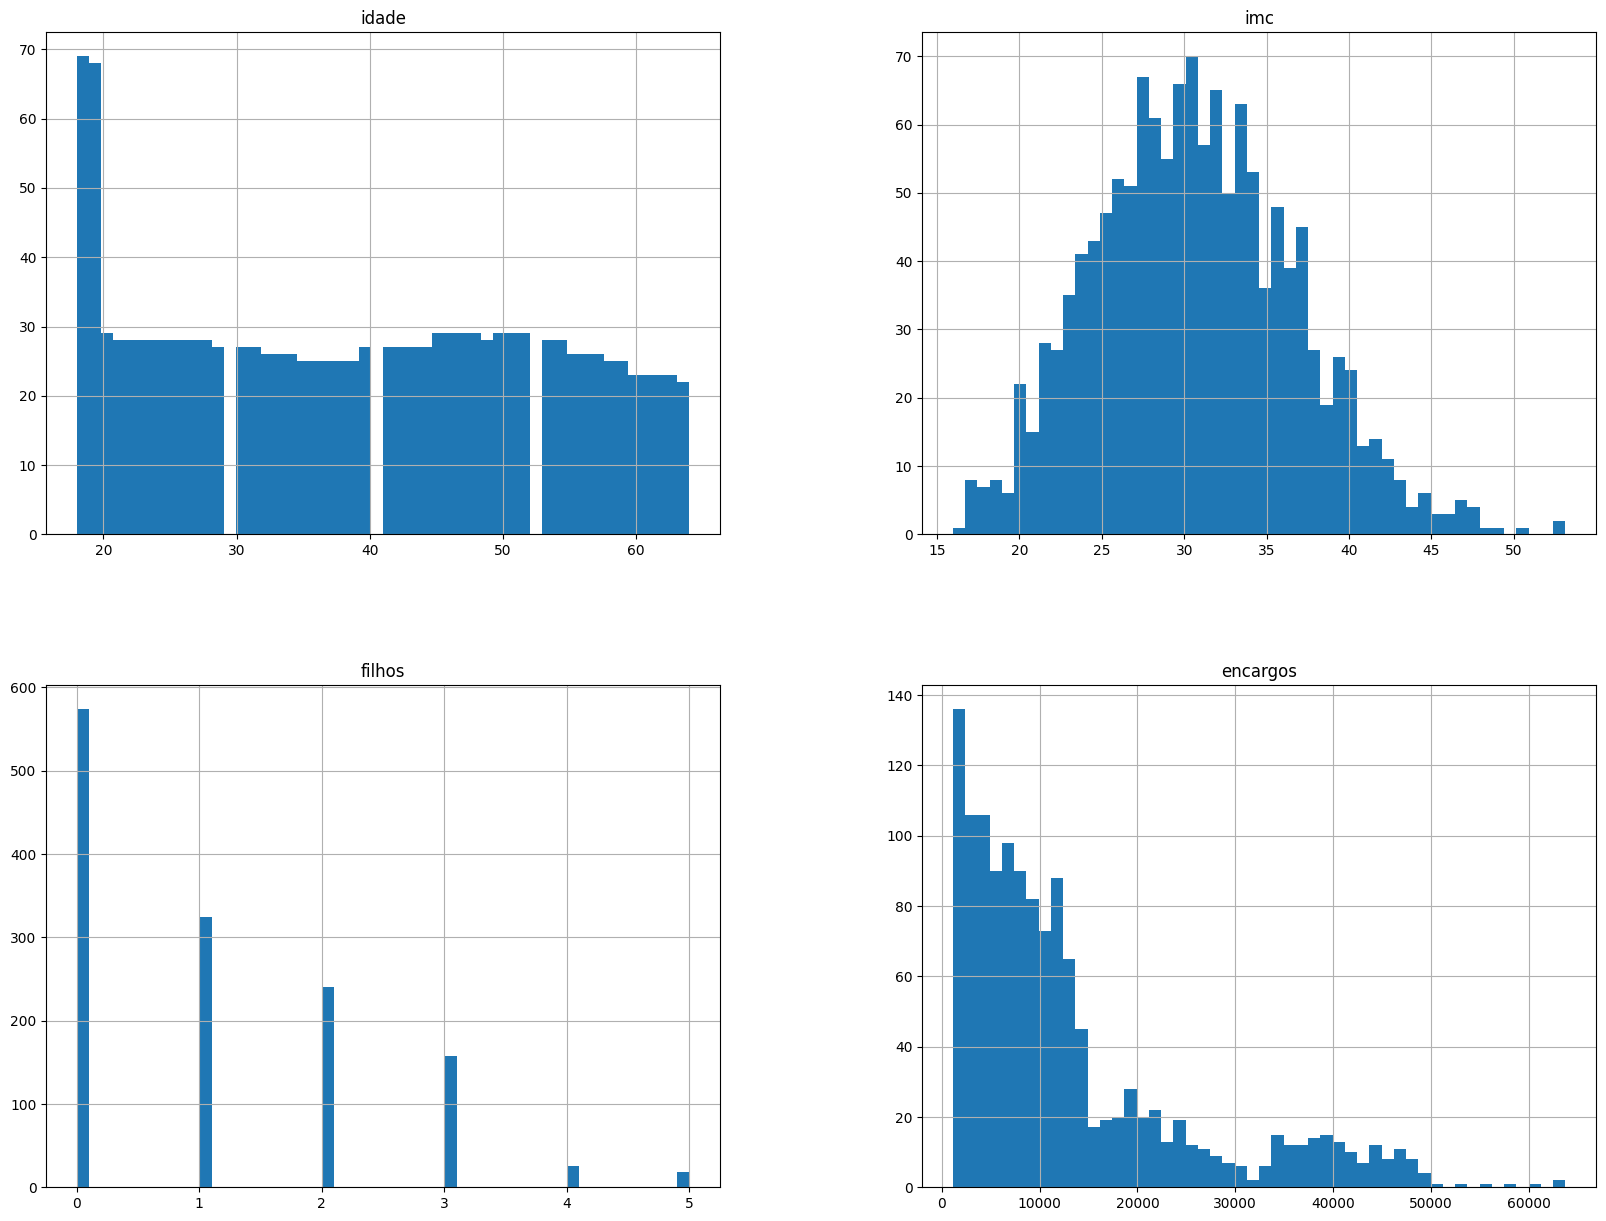

In [50]:
dataset.hist(bins=50, figsize=(20,15))

### 2. Pré-processamento dos dados

- Transformaremos as colunas não-numéricas ("gênero", "fumante" e "região") em numéricas
- Agruparemos os valores de "imc" em faixas

In [51]:
np.random.seed(42)

def preprocess_dataset(dataset): 

    dataset["faixas_imc"] = pd.cut(dataset["imc"],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

    label_encoder = LabelEncoder()

    dataset['genero_type'] = label_encoder.fit_transform(dataset['gênero'])
    dataset['fumante_type'] = label_encoder.fit_transform(dataset['fumante'])
    dataset['regiao_type'] = label_encoder.fit_transform(dataset['região'])

    dataset_tratado = dataset.drop(columns = [ "imc", "fumante", "região", "gênero"]).copy()

    return dataset_tratado


In [52]:
dataset_tratado = preprocess_dataset(dataset)
dataset_tratado.head()

,idade,filhos,encargos,faixas_imc,genero_type,fumante_type,regiao_type
0,19,0,16884.92400,3,0,1,3
1,18,1,1725.55230,4,1,0,2
2,28,3,4449.46200,4,1,0,2
3,33,0,21984.47061,2,1,0,1
4,32,0,3866.85520,3,1,0,1


### 3. Estratificação das bases de treino e teste

Analisando as correlações, apesar de "fumante_type" e "idade" apresentarem uma correlação maior com "encargos", optamos por estratificar as amostras de treino e teste utilizando a coluna "faixas_imc" pelo comportamento "normal" de distribuição na base.

In [53]:
corr_matrix = dataset_tratado.corr()
corr_matrix["encargos"].sort_values(ascending=False)

encargos        1.000000
fumante_type    0.787251
idade           0.299008
faixas_imc      0.205401
filhos          0.067998
genero_type     0.057292
regiao_type    -0.006208
Name: encargos, dtype: float64

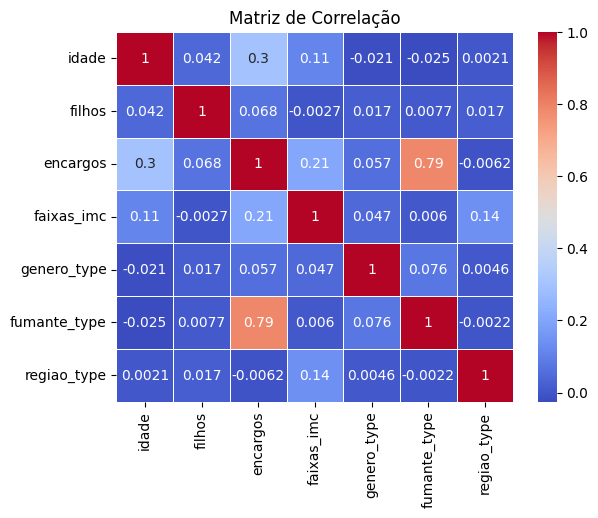

In [54]:
# Exibir o gráfico de correlação usando Seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [55]:

def stratified_split(dataset):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(dataset, dataset["faixas_imc"]):
        strat_train_set = dataset.loc[train_index]
        strat_test_set = dataset.loc[test_index]

    print("Proporções na base de treino")
    print(strat_train_set["faixas_imc"].value_counts() / len(strat_train_set))
    print("Proporções na base de teste")
    print(strat_test_set["faixas_imc"].value_counts() / len(strat_test_set))

    # Removendo a coluna faixas_imc
    for set_ in (strat_train_set, strat_test_set):
      set_.drop("faixas_imc", axis=1, inplace=True)

    X_train = strat_train_set.copy()
    y_train = X_train["encargos"].copy()     

    X_train = X_train.drop(columns=['encargos'], axis=1)

    X_test = strat_test_set.copy()
    y_test = X_test["encargos"].copy()

    X_test = X_test.drop(columns=['encargos'], axis=1)


    return X_train, y_train, X_test, y_test

In [56]:

X_train, y_train, X_test, y_test = stratified_split(dataset_tratado)


Proporções na base de treino
faixas_imc
4    0.296262
3    0.284112
5    0.169159
2    0.165421
6    0.069159
1    0.015888
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.283582
5    0.167910
2    0.164179
6    0.070896
1    0.014925
Name: count, dtype: float64


### 4. Execução e avaliação de vários modelos

- Testaremos vários modelos
    - LinearRegression
    - DecisionTreeRegressor
    - RandomForestRegressor
    - GradientBoostingRegressor
    - HuberRegressor
- Para cada um deles, plotamos um gráfico comparando os valores previstos (eixo Y) com os valores reais (eixo X). Quanto mais próximo da linha ideal, melhor

In [57]:

def evaluate_model(model, X_train, y_train, y_test, predictions, model_results):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, predictions)
    errors = np.abs(y_test - predictions)
    relative_errors = errors / np.abs(y_test)
    mape = np.mean(relative_errors) * 100

    # Cross Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

    model_results.append({
        'model': model.__class__.__name__,
        'mae': mae.round(2),
        'mse': mse.round(2),
        'rmse': rmse.round(2),
        'r2': r2.round(4),
        'mape': mape.round(2),
        'K=5 cross-val (r2) mean': scores.mean().round(4),
        'K=5 cross-val (r2) deviation': scores.std().round(4)
    })

    plt.scatter(y_test, predictions)
    plt.xlabel('Encargo Real')
    plt.ylabel('Encargo Previsto')
    
    plt.title('Real vs Previsto - ' + model.__class__.__name__)


    ideal_values = np.linspace(min(y_test), max(y_test)) 
    plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
    plt.legend()
    plt.show()


def run_model(model, X_train, y_train, X_test, y_test, model_results):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    evaluate_model(model, X_train, y_train, y_test, predictions, model_results)


def run_all_models(X_train, y_train, X_test, y_test):
    model_results = []

    models = [
        LinearRegression(),
        DecisionTreeRegressor(),
        GradientBoostingRegressor(),
        RandomForestRegressor(),
        HuberRegressor()
    ]

    for model in models:
        run_model(model, X_train, y_train, X_test, y_test, model_results)

    return model_results

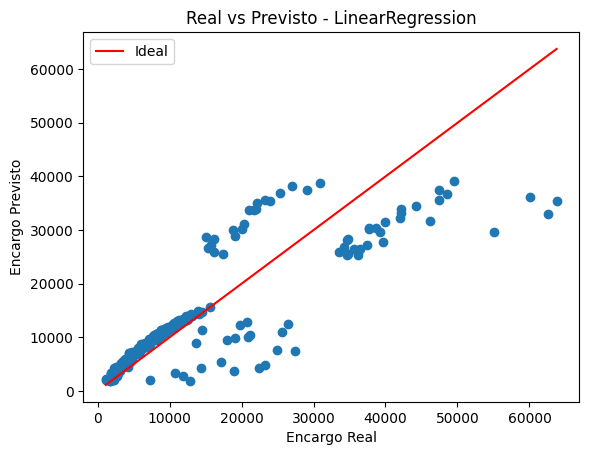

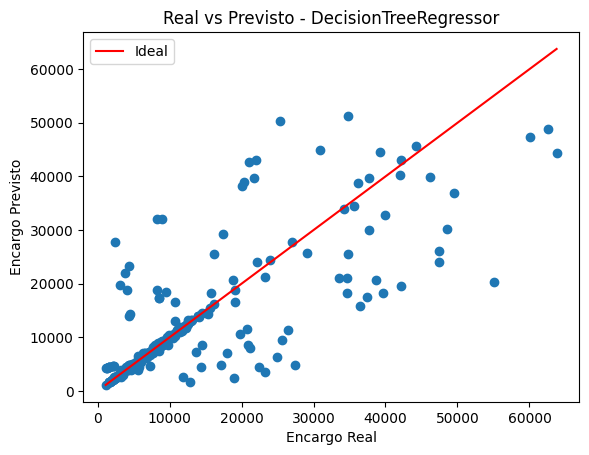

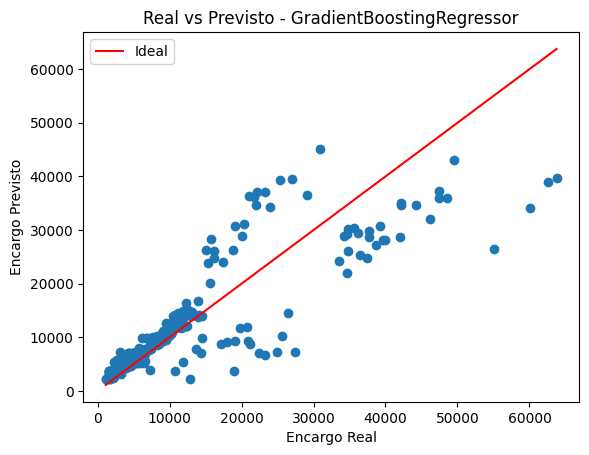

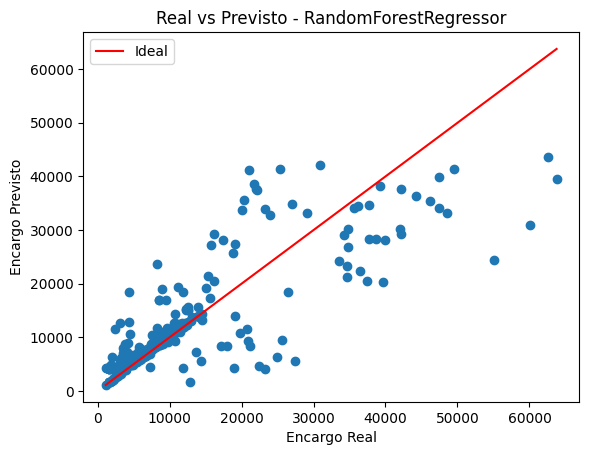

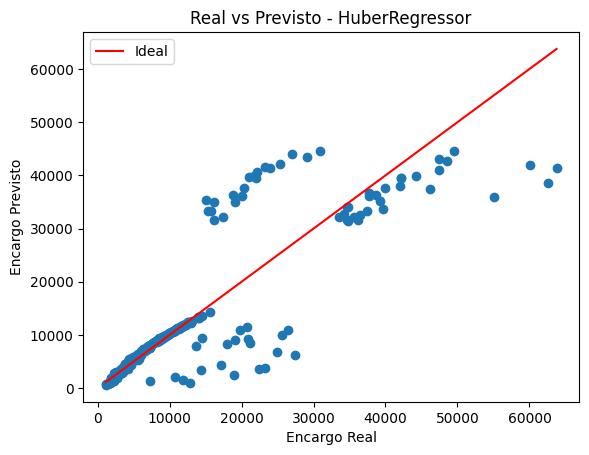

In [58]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

In [59]:
model_results_df = pd.DataFrame(model_results)

model_results_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,4100.91,42149780.10,6492.29,0.7206,31.83,0.7154,0.0355
1,DecisionTreeRegressor,3907.51,62678520.26,7916.98,0.5845,35.83,0.4593,0.0442
2,GradientBoostingRegressor,3998.64,41482944.64,6440.73,0.7250,34.84,0.7050,0.0353
3,RandomForestRegressor,3976.07,48121673.48,6936.98,0.6810,36.00,0.6503,0.0330
4,HuberRegressor,3244.60,43898153.23,6625.57,0.7090,21.32,0.6560,0.0852


### 5. Insights e melhorias, re-execução do passo 4

Análise do valor máximo e médio dos encargos.

In [60]:
print("Valor máximo dos encargos:", dataset_tratado['encargos'].max())

Valor máximo dos encargos: 63770.42801


In [61]:
print("Valor médio dos encargos:", dataset_tratado['encargos'].mean())

Valor médio dos encargos: 13270.422265141257


Análise da variação de amplitude da variável encargos.

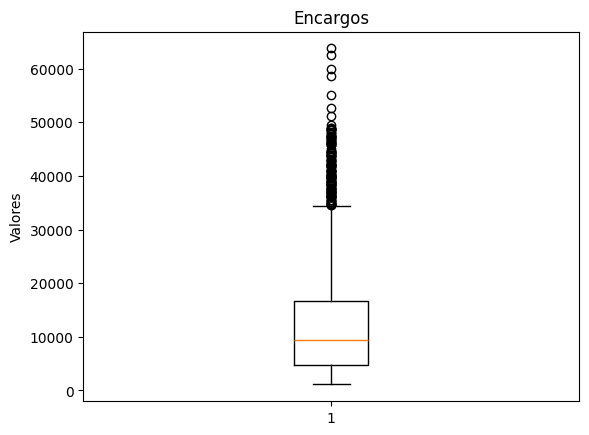

In [62]:
import matplotlib.pyplot as plt

# Criar o gráfico de boxplot
plt.boxplot(dataset_tratado['encargos'])
plt.title('Encargos')
plt.ylabel('Valores')
plt.show()

***Estratégia 1: Observaremos o comportamento dos modelos retirando-se os 25% da base cujo encargo é maior que o 75th percetile***

In [63]:
def recuperar_valor_quartil(data, quartil):
    """
    Calcula o valor do quartil especificado para os dados fornecidos.

    Parâmetros:
        data (array): Array contendo os dados.
        quartil (int): Número do quartil desejado (25, 50 ou 75).

    Retorna:
        float: Valor do quartil especificado.
    """
    return np.percentile(data, quartil)

Q3 = recuperar_valor_quartil(dataset_tratado['encargos'], 75)

dataset_ajustado = dataset_tratado[dataset_tratado['encargos'] <= Q3]

dataset_ajustado.reset_index(drop=True, inplace=True)

X_train, y_train, X_test, y_test = stratified_split(dataset_ajustado)

Proporções na base de treino
faixas_imc
4    0.298005
3    0.288030
2    0.172070
5    0.155860
6    0.067332
1    0.018703
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.288557
2    0.169154
5    0.154229
6    0.069652
1    0.019900
Name: count, dtype: float64


**Testando novamente os modelos**

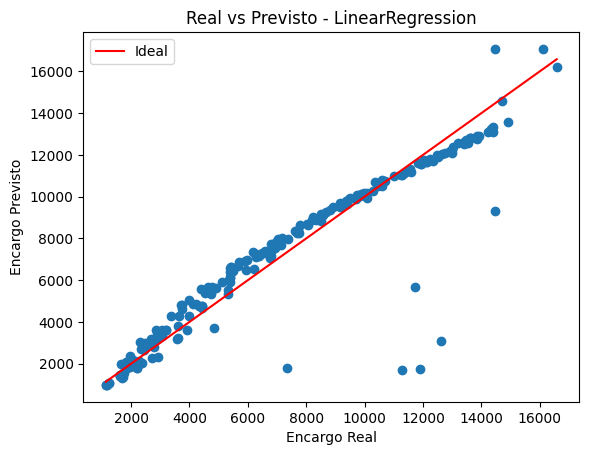

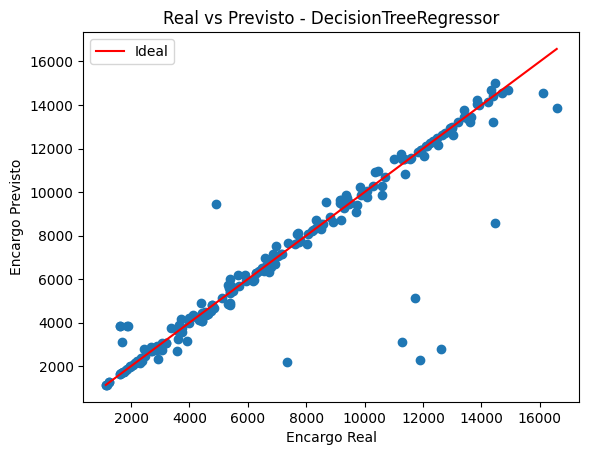

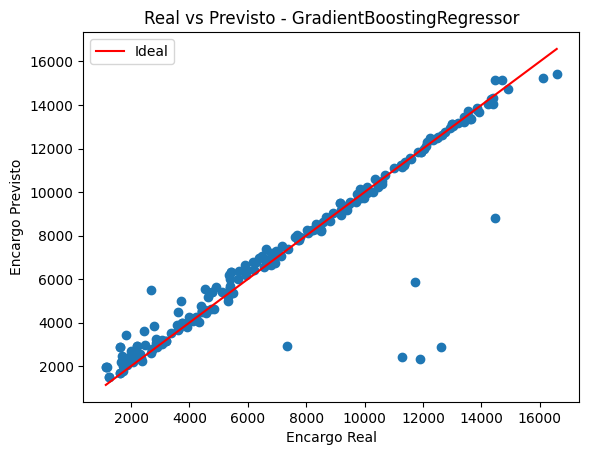

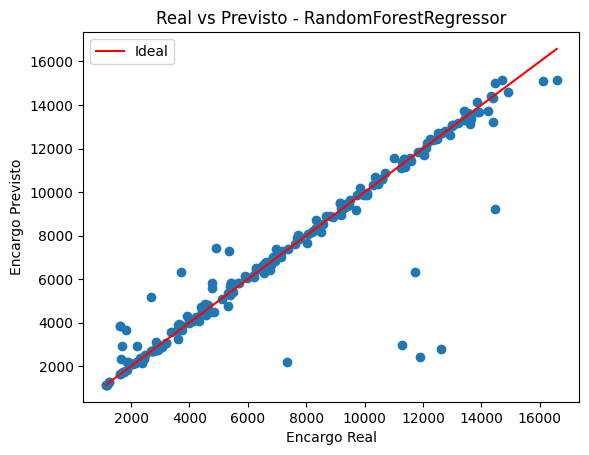

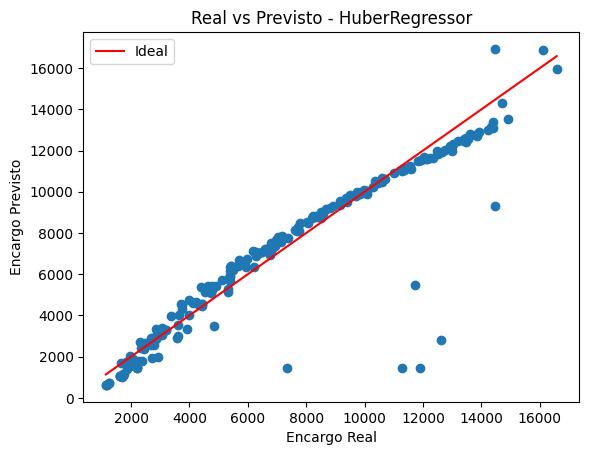

In [64]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

In [65]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,765.08,2301312.40,1517.01,0.8652,11.79,0.8828,0.0375
1,DecisionTreeRegressor,486.62,2115320.62,1454.41,0.8761,8.12,0.8269,0.0815
2,GradientBoostingRegressor,502.75,1943968.27,1394.26,0.8861,10.30,0.8859,0.0420
3,RandomForestRegressor,465.10,1943745.79,1394.18,0.8862,8.24,0.8749,0.0451
4,HuberRegressor,729.32,2355039.12,1534.61,0.8621,12.33,0.8810,0.0391


***Estratégia 2: Utilizaremos upsampling para aumentar a nossa amostra original e verificar o comportamento dos modelos***

In [66]:
upsample_dataset = dataset.sample(n=5000, replace=True, random_state=42, ignore_index=True)

upsample_dataset_tratado = preprocess_dataset(upsample_dataset)

upsample_dataset_tratado.describe()

,idade,filhos,encargos,genero_type,fumante_type,regiao_type
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,39.249600,1.074000,13429.083801,0.501800,0.213800,1.517000
std,14.110093,1.181526,12324.765853,0.500047,0.410028,1.106145
min,18.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,26.750000,0.000000,4661.286350,0.000000,0.000000,1.000000
50%,39.000000,1.000000,9411.005000,1.000000,0.000000,2.000000
75%,51.000000,2.000000,17468.983900,1.000000,0.000000,2.000000
max,64.000000,5.000000,63770.428010,1.000000,1.000000,3.000000


In [67]:
X_train, y_train, X_test, y_test = stratified_split(upsample_dataset_tratado)

Proporções na base de treino
faixas_imc
4    0.28700
3    0.28625
2    0.17050
5    0.16750
6    0.07325
1    0.01550
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
3    0.287
4    0.287
2    0.170
5    0.167
6    0.073
1    0.016
Name: count, dtype: float64


**Testando novamente os modelos**

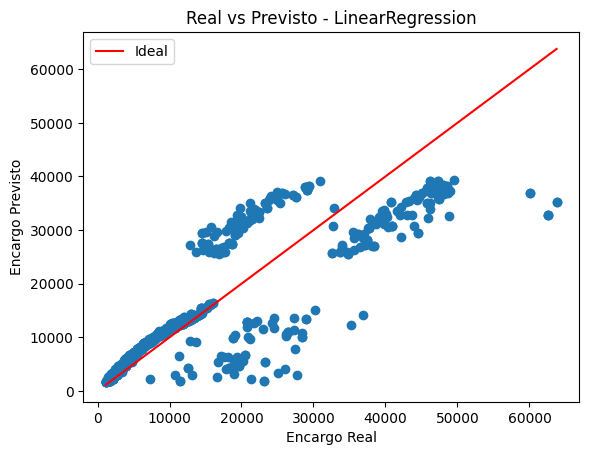

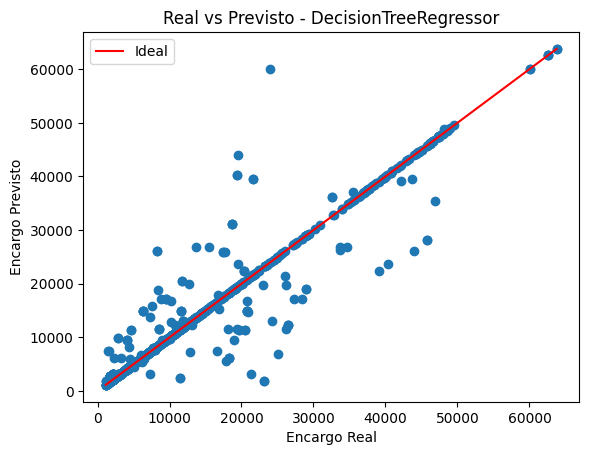

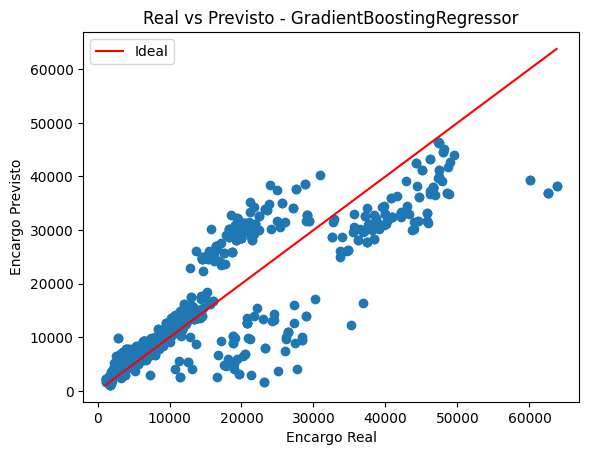

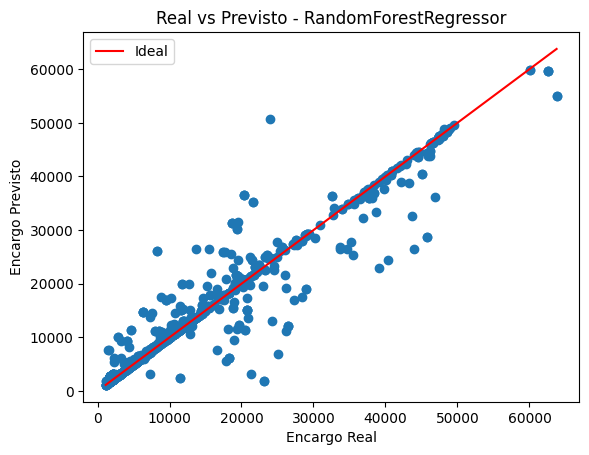

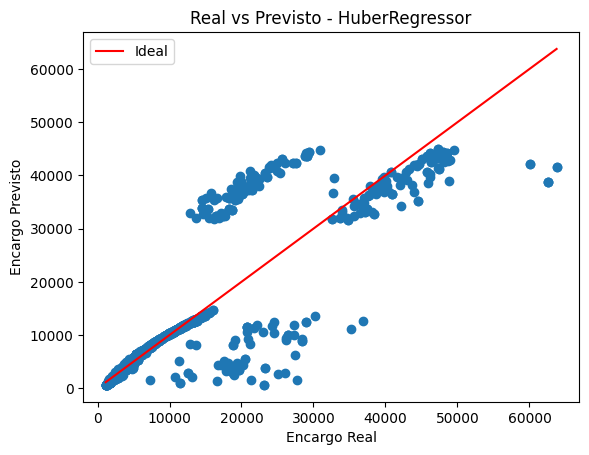

In [68]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

In [69]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,4220.50,43254922.74,6576.85,0.7271,30.87,0.7246,0.0181
1,DecisionTreeRegressor,1042.08,12952253.41,3598.92,0.9183,9.69,0.9180,0.0138
2,GradientBoostingRegressor,3787.92,35634520.74,5969.47,0.7752,31.15,0.7617,0.0189
3,RandomForestRegressor,1329.80,12580694.23,3546.93,0.9206,11.66,0.9189,0.0077
4,HuberRegressor,3686.86,52777549.53,7264.82,0.6670,22.73,0.6663,0.0254
